<a href="https://colab.research.google.com/github/nnshoshin/projects/blob/main/praktikum_telecom_shoshin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Телеком - описание проекта.

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах. На основе имеющихся данных будем предсказывать отток клиента.  
Основная метрика: AUC-ROC.
Дополнительная метрика: Accuracy.


## Исследовательский анализ данных

Подгрузим необходимые библиотеки:

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import seaborn as sn
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

Загрузим данные:

In [ ]:
df_contracts = pd.read_csv('/datasets/final_provider/contract.csv') 
df_personal = pd.read_csv('/datasets/final_provider/personal.csv') 
df_internet = pd.read_csv('/datasets/final_provider/internet.csv') 
df_phone = pd.read_csv('/datasets/final_provider/phone.csv') 

Посмотрим на полученные данные:

In [ ]:
for i in [df_contracts, df_personal, df_internet, df_phone]:
    display(i)
    display(i.info())
    display(i.describe())
    print('Дубликатов:', i.duplicated().sum())
    print('Пропусков:',  i.isnull().mean())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
customerID          7043 non-null object
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Дубликатов: 0
Пропусков: customerID          0.0
BeginDate           0.0
EndDate             0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
customerID       7043 non-null object
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Дубликатов: 0
Пропусков: customerID       0.0
gender           0.0
SeniorCitizen    0.0
Partner          0.0
Dependents       0.0
dtype: float64


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
customerID          5517 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,2798-NYLMZ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Дубликатов: 0
Пропусков: customerID          0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
dtype: float64


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
customerID       6361 non-null object
MultipleLines    6361 non-null object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,2129-ALKBS,No
freq,1,3390


Дубликатов: 0
Пропусков: customerID       0.0
MultipleLines    0.0
dtype: float64


Первые выводы: 
1. Данные на первый взгляд корректные. Пропусков и дубликатов не имеется. 
2. Столбец TotalCharges имеет тип object, надо заменить на float. 
3. Столбцы с датами нужно заменить на тип datetime
4. 5517 контрактов включают в себя услуги интернета, 6361 - услуги телефонии. В сумме это больше, чем общее количество контрактов, значит большинство контрактов включает в себе 2 типа услуг.  

Посмотрим на целевой признак:

In [ ]:
df_contracts['EndDate'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: EndDate, dtype: float64

Видно, что активный отток клиентов начался 4 месяца назад. С октября 2019 стабильно отваливается порядка 7 процентов клиентов в месяц. Как мы выяснили в процессе консультации - это связано с появлением конкурента, который стал стабильно отнимать клиентов. Это нужно как-то остановить или хотя бы замедлить, поэтому займемся построением модели, которая будет находить возможных перебежчиков. Этим людям будет предлагать спецусловия, которые убедят их остаться лояльными оператору. 

## План дальнейшей работы и возникшие вопросы:

План:

1. Выделить в отдельную колонку целевой признак "churn", в котором 1 будет означать, что клиент ушел, а 0, что клиент еще с нами.
2. Выделить в отдельную колонку признак lifetime, в котором будет срок, количество месяцев, в течение которых клиент пользовался услугами.
3. Берем за основу таблицу contracts, добавляем туда признаки internet и phone, в которых будут стоять 0 и 1 в зависимости от того, есть ли в контракте эти услуги.
4. Джойним к этой таблице соц-дем данные о клиенте из таблицы df_personal, а также более подробную расшифровку дополнительных услуг из таблиц df_internet и df_phone. 
5. Проверяем на мультиколлинеарность. Есть ощущение, что между признаками lifetime, MonthlyCharges и TotalCharges будет очень сильная корреляция. Подумаем, что из этого можно выкинуть. 
6. Убираем BeginDate и EndDate - ненужные столбцы с датами. 
7. Делим выборки на обучающую и тестовую, кодируем категориальные переменные, устраняем дисбаланс классов.
8. После всей предобработки приступаем к обучению разных моделей и подбору гиперпараметров. 

Вопросы:
В целом вопросов не возникло. Единственное - в описании к заданию не сказано, что содержится в таблице df_personal. Правильно ли я понял, что
- gender - пол клиента
- SeniorCitizen - является ли клиент пенсионером
- Partner - женат\замужем ли клиент
- Dependents - есть ли иждивенцы или дети ?

## Предобработка:

Переведём столбец TotalCharges в формат float:

In [ ]:
#df_contracts['TotalCharges'] = df_contracts['TotalCharges'].astype(float)
df_contracts['TotalCharges_new'] = pd.to_numeric(df_contracts['TotalCharges'], errors = 'coerce')
df_contracts[df_contracts['TotalCharges_new'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalCharges_new
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,NaN


Сразу не получилось сделать, astype выдавал ошибку. Попробовал другим способом и вывел проблемные колонки. Оказалось проблема в том, что есть часть клиентов, которые еще не успели ни разу оплатить за услуги. 

Уберём эти колонки, так как они не нужны для обучения. По этим строкам не ясно, останется ли клиент и будет ли вообще платить за услуги. 

In [ ]:
df_contracts.dropna(subset=['TotalCharges_new'], inplace=True)
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7032 non-null object
BeginDate           7032 non-null object
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null object
TotalCharges_new    7032 non-null float64
dtypes: float64(2), object(7)
memory usage: 549.4+ KB


Переведём столбец с датой начала в формат datetime:

In [ ]:
df_contracts['BeginDate'] = pd.to_datetime(df_contracts['BeginDate'])
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 9 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             7032 non-null object
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null object
TotalCharges_new    7032 non-null float64
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 549.4+ KB


Создадим целевой столбец с предсказанием оттока клиента:

In [ ]:
df_contracts['churn'] = df_contracts['EndDate'].apply(lambda x: 0 if x=='No' else 1 )

Переведем столбец EndDate в datetime. Мы знаем, что у некоторых контракт еще не закончился, поэтому добавим errors = 'coerce', чтобы ошибки превратились в незвестные значения. 

In [ ]:
df_contracts['EndDate'] = pd.to_datetime(df_contracts['EndDate'] , errors = 'coerce')
df_contracts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
customerID          7032 non-null object
BeginDate           7032 non-null datetime64[ns]
EndDate             1869 non-null datetime64[ns]
Type                7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null object
TotalCharges_new    7032 non-null float64
churn               7032 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(1), object(5)
memory usage: 604.3+ KB


Создадим столбец Lifetime - какое количество месяцев человек являлся клиентом компании. 

In [ ]:
df_contracts['lifetime'] = ((df_contracts.EndDate - df_contracts.BeginDate)/np.timedelta64(1, 'M'))
df_contracts['lifetime'] = df_contracts['lifetime'].mask(df_contracts['lifetime'].isna(), (datetime.strptime('2020-02-01', '%Y-%m-%d') - df_contracts['BeginDate'])/np.timedelta64(1, 'M') )
df_contracts['lifetime'] = df_contracts['lifetime'].astype(int)

In [ ]:
df_contracts

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalCharges_new,churn,lifetime
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,29.85,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.5,1889.50,0,34
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,108.15,1,2
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,1840.75,0,45
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,151.65,1,2
...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,Yes,Mailed check,84.80,1990.5,1990.50,0,23
7039,2234-XADUH,2014-02-01,NaT,One year,Yes,Credit card (automatic),103.20,7362.9,7362.90,0,71
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,Yes,Electronic check,29.60,346.45,346.45,0,11
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,Yes,Mailed check,74.40,306.6,306.60,1,4


Удалим ненужные для обучения столбцы.

In [ ]:
df_contracts.drop(['BeginDate', 'EndDate', 'TotalCharges'], axis=1, inplace=True)
df_contracts

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges_new,churn,lifetime
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,23
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,71
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,11
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4


Добавим столбцы, которые покажут, какими услугами пользуется каждый из клиентов:

In [ ]:
df_contracts['internet'] = df_contracts['customerID'].apply(lambda x:1 if x in df_internet['customerID'].values else 0)
df_contracts['phone'] = df_contracts['customerID'].apply(lambda x:1 if x in df_phone['customerID'].values else 0)
df_contracts

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges_new,churn,lifetime,internet,phone
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,1,0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34,1,1
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,1,1
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,1,0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,23,1,1
7039,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,71,1,1
7040,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,1,0
7041,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,1,1


Присоединим к таблице данные о доп услугах телефонии:

In [ ]:
df_contracts = df_contracts.merge(df_phone, how='left', on='customerID')
df_contracts

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges_new,churn,lifetime,internet,phone,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,1,0,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34,1,1,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,1,1,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,1,0,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,1,1,No
...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,23,1,1,Yes
7028,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,71,1,1,Yes
7029,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,1,0,NaN
7030,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,1,1,Yes


Присоединим к таблице данные о доп услугах интернета:

In [ ]:
df_contracts = df_contracts.merge(df_internet, how='left', on='customerID')
df_contracts 

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges_new,churn,lifetime,internet,phone,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,1,0,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34,1,1,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,1,1,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,1,0,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,1,1,No,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,23,1,1,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes
7028,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,71,1,1,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes
7029,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,1,0,NaN,DSL,Yes,No,No,No,No,No
7030,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,1,1,Yes,Fiber optic,No,No,No,No,No,No


Присоединим к таблице соц-дем данные о клиентах:

In [ ]:
df_contracts = df_contracts.merge(df_personal, how='left', on='customerID')
df_contracts 

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges_new,churn,lifetime,internet,phone,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1,1,0,...,No,Yes,No,No,No,No,Female,0,Yes,No
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34,1,1,...,Yes,No,Yes,No,No,No,Male,0,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2,1,1,...,Yes,Yes,No,No,No,No,Male,0,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45,1,0,...,Yes,No,Yes,Yes,No,No,Male,0,No,No
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2,1,1,...,No,No,No,No,No,No,Female,0,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,23,1,1,...,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes
7028,2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,71,1,1,...,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes
7029,4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,11,1,0,...,Yes,No,No,No,No,No,Female,0,Yes,Yes
7030,8361-LTMKD,Month-to-month,Yes,Mailed check,74.40,306.60,1,4,1,1,...,No,No,No,No,No,No,Male,1,Yes,No


У нас появились пропуски, так как не все клиенты пользуются одновременно и интернетом, и телефоном.

In [ ]:
df_contracts.isnull().mean()

customerID          0.000000
Type                0.000000
PaperlessBilling    0.000000
PaymentMethod       0.000000
MonthlyCharges      0.000000
TotalCharges_new    0.000000
churn               0.000000
lifetime            0.000000
internet            0.000000
phone               0.000000
MultipleLines       0.096701
InternetService     0.216155
OnlineSecurity      0.216155
OnlineBackup        0.216155
DeviceProtection    0.216155
TechSupport         0.216155
StreamingTV         0.216155
StreamingMovies     0.216155
gender              0.000000
SeniorCitizen       0.000000
Partner             0.000000
Dependents          0.000000
dtype: float64

Заполним их:

In [ ]:
df_contracts.fillna('No', inplace=True)
df_contracts.isnull().mean()

customerID          0.0
Type                0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges_new    0.0
churn               0.0
lifetime            0.0
internet            0.0
phone               0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
dtype: float64

Проверим признаки на мультиколлинеарность:

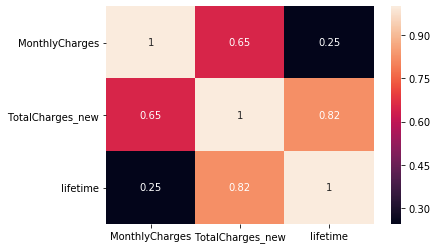

In [ ]:
corr_matrix = df_contracts[['MonthlyCharges', 'TotalCharges_new', 'lifetime']].corr()
sn.heatmap(corr_matrix, annot=True)

Удалим колонку TotalCharges_new, так как она сильно коррелирует с MonthlyCharges и lifetime. Это логично, так как скорее всего она появилась умножением последних двух. 

Помимо этого я удалил еще много столбцов. Почему я посчитал их ненужными, сказано ниже. 

In [ ]:
df_contracts.drop(['customerID', 'TotalCharges_new', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner',
       'Dependents', 'internet', 'phone', 'Type', 'gender', 'MultipleLines', 'PaperlessBilling'], axis=1, inplace=True)

In [ ]:
df_contracts

,PaymentMethod,MonthlyCharges,churn,lifetime,InternetService
0,Electronic check,29.85,0,1,DSL
1,Mailed check,56.95,0,34,DSL
2,Mailed check,53.85,1,2,DSL
3,Bank transfer (automatic),42.30,0,45,DSL
4,Electronic check,70.70,1,2,Fiber optic
...,...,...,...,...,...
7027,Mailed check,84.80,0,23,DSL
7028,Credit card (automatic),103.20,0,71,Fiber optic
7029,Electronic check,29.60,0,11,DSL
7030,Mailed check,74.40,1,4,Fiber optic


## Обучение модели

Разделим выборки на обучающую и тестовую:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(df_contracts.drop('churn', axis=1), df_contracts['churn'], test_size=0.2)
print(features_train.shape,features_test.shape, target_train.shape, target_test.shape )

(5625, 4) (1407, 4) (5625,) (1407,)


Обучим Catboost на обучающей выборке:

In [ ]:
modelcat = CatBoostClassifier( cat_features=[ 'PaymentMethod',
         'InternetService'])
modelcat.fit(features_train, target_train)

Learning rate set to 0.027315
0:	learn: 0.6762473	total: 55.5ms	remaining: 55.5s
1:	learn: 0.6629638	total: 61.2ms	remaining: 30.5s
2:	learn: 0.6472709	total: 106ms	remaining: 35.1s
3:	learn: 0.6335794	total: 111ms	remaining: 27.7s
4:	learn: 0.6215278	total: 116ms	remaining: 23s
5:	learn: 0.6109402	total: 204ms	remaining: 33.7s
6:	learn: 0.5997243	total: 209ms	remaining: 29.6s
7:	learn: 0.5889553	total: 214ms	remaining: 26.5s
8:	learn: 0.5810938	total: 304ms	remaining: 33.5s
9:	learn: 0.5723114	total: 309ms	remaining: 30.6s
10:	learn: 0.5631214	total: 400ms	remaining: 36s
11:	learn: 0.5549108	total: 405ms	remaining: 33.4s
12:	learn: 0.5490286	total: 410ms	remaining: 31.1s
13:	learn: 0.5420110	total: 499ms	remaining: 35.1s
14:	learn: 0.5345936	total: 506ms	remaining: 33.2s
15:	learn: 0.5292280	total: 509ms	remaining: 31.3s
16:	learn: 0.5232635	total: 596ms	remaining: 34.5s
17:	learn: 0.5172859	total: 601ms	remaining: 32.8s
18:	learn: 0.5114323	total: 606ms	remaining: 31.3s
19:	learn: 0.

Проверим модель на тестовой выборке и выведем целевые метрики:

In [ ]:
y_pred_modelcat_test = modelcat.predict(features_test)
roc_auc_test = roc_auc_score(target_test, modelcat.predict_proba(features_test)[:, 1])
acc_test = accuracy_score(y_pred_modelcat_test, target_test)
print('ROC_AUC = ', roc_auc_test, ', Accuracy = ', acc_test)

ROC_AUC =  0.8687297713578037 , Accuracy =  0.835820895522388


Мы видим, что ROC_AUC получилась больше 0,86, что соответствует поставленной задаче. 

Далее я проверял важность признаков и удалял самые неважные из них. Это помогло улучшить метрику Roc_Auc на несколько сотых. Поэтому выше я удалил много колонок из признаков - модель посчитала их неважными. 

In [ ]:
modelcat.get_feature_importance()

array([ 8.98900927, 21.86333194, 53.56477139, 15.5828874 ])

Мы видим, что наибольшее влияние на модель имеет lifetime и Monthly charges. Посмотрим на зависимость подробнее:

churn = 0


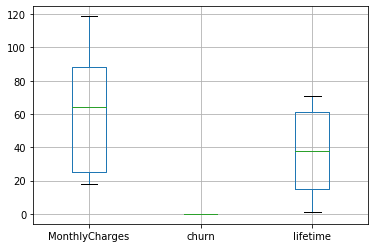

churn = 1


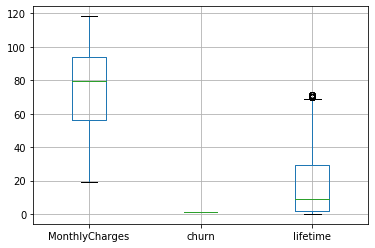

In [ ]:
for i in df_contracts['churn'].unique():
    print('churn =', i)
    df_contracts[df_contracts['churn']==i].boxplot()
    plt.show()

Из графиков видно, что оттекают более "свежие" клиенты, а также ежемесячный платеж у оттекающих клиентов выше, чем у тех, кто остается. Видимо оператор - конкурент заманивает еще до конца неопределившихся клиентов более дешевыми ценами. 

Сравним Accuracy нашей модели с константной:

In [ ]:
dummy_pred = np.zeros(y_pred_modelcat_test.shape)
acc_dummy = accuracy_score(dummy_pred, target_test)
print(acc_dummy)

0.736318407960199


Проверка пройдена, модель работаем лучше чем dummy-предсказания. 

## Вывод

В ходе проекта удалось построить модель, предсказывающую отток клиентов оператора связи «Ниединогоразрыва.ком» . Метрика качества ROC_AUC удовлетворила условию на 5 sp и составила 0.868. Метрика Accuracy 0.836, что выше Accuracy константной модели на 13%. 

В процессе работы был выполнен исследовательский анализ данных, предобработка, генерация фич, обучение модели и файнтюнинг модели Catboostclassifier. 

Удалось выяснить, что наибольшее влияние на отток клиентов оказывают признаки:

- Monthly charges. Cреди тех, кто отказался от услуг оператора медианные ежемесячные расходы примерно на 25% выше
- Lifetime. Cреди тех, кто отказался от услуг оператора медианное Lifetime составляем 4 месяца. Тогда как, у тех, кто остается лояльным компании, оно составляет около 40 месяцев. 

В связи с этим можно видвинуть предложение для бизнеса, чтобы подумали над бонусами для новых клиентов. Например, на первые полгода после подписания договора давать какую-то скидку на услуги связи, чтобы клиент продержался эти полгода, выработал лояльность, после чего вероятность его оттока снижается. 